### Instructions
This script is to run a trained CNN model on ArcGIS aeriam imagery
1. Configure the paramers as required
2. Run all cells up to ***Display ArcGIS map***
3. Once the map is loaded, run the ***Export map from ArcGIS service*** to export the map
4. Once the map is downloaded, run the ***Binary classifer*** or ***Multiclass classifer***

### Imports
imports the required modules from keras, Tensorflow, PIL, numpy and custom file handling functions

In [6]:
import arcgis
from arcgis.gis import GIS
from ipywidgets import Layout
from PIL import Image
from keras.preprocessing import image
from keras.models import load_model, model_from_json
from keras import optimizers, regularizers, models, layers
import requests
from io import BytesIO
from urllib.parse import urlencode
from os import listdir, remove, mkdir
from os.path import join, exists, expanduser, isdir
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from utils.file_utils import make_dir_helper, is_jpeg, delete_dir_helper, delete_dir_files_helper
import numpy as np
from arcgis.geometry import Envelope
from keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict

### Configurable parameters

Defines various constants, directory paths.

In [2]:
PROJECT_DIR = join(expanduser('~'),'desktop','Esri Project');
MAP_NAME = 'map.jpg'
TEMP_DIR = join(PROJECT_DIR, 'temp data')
TEMP_SLICED_DIR = join(TEMP_DIR, 'temp sliced')
TEMP_SLICED_SUBDIR = join(TEMP_SLICED_DIR, 'map sliced')
DATA_DIR = join(PROJECT_DIR, 'datasets', 'redlands dataset')
MODEL_DIR =  join(expanduser('~'),  PROJECT_DIR, 'models');
OUTPUT_DIR = join(PROJECT_DIR, 'outputs')
SLICE_WIDTH, SLICE_HEIGHT = 256, 256
MAP_WIDTH, MAP_HEIGHT = 4096, 4096
BATCH_SIZE = 10
IMAGE_SIZE = 128

### Make required directories
Make the directories for temporary data

In [3]:
# Delete the previous data folder and all its contents
delete_dir_helper(TEMP_DIR)

make_dir_helper(TEMP_DIR)
AUG_DIR = join(TEMP_DIR, 'augmented images')
make_dir_helper(AUG_DIR)
make_dir_helper(TEMP_SLICED_DIR)
make_dir_helper(TEMP_SLICED_SUBDIR)

True

### Display ArcGIS map
Show the redlands satellite area using Python API 

In [4]:
gis = GIS()
arc_map = gis.map('Redlands')

arc_map.basemap = 'satellite'
arc_map

### Export map from ArcGIS service
Export the map from the ArcGIS online service based on the given extent

{'type': 'extent', 'xmin': -13043537.000969624, 'ymin': 4035872.34275381, 'xmax': -13042340.283745637, 'ymax': 4036350.074180552, 'spatialReference': {'wkid': 102100, 'latestWkid': 3857}}


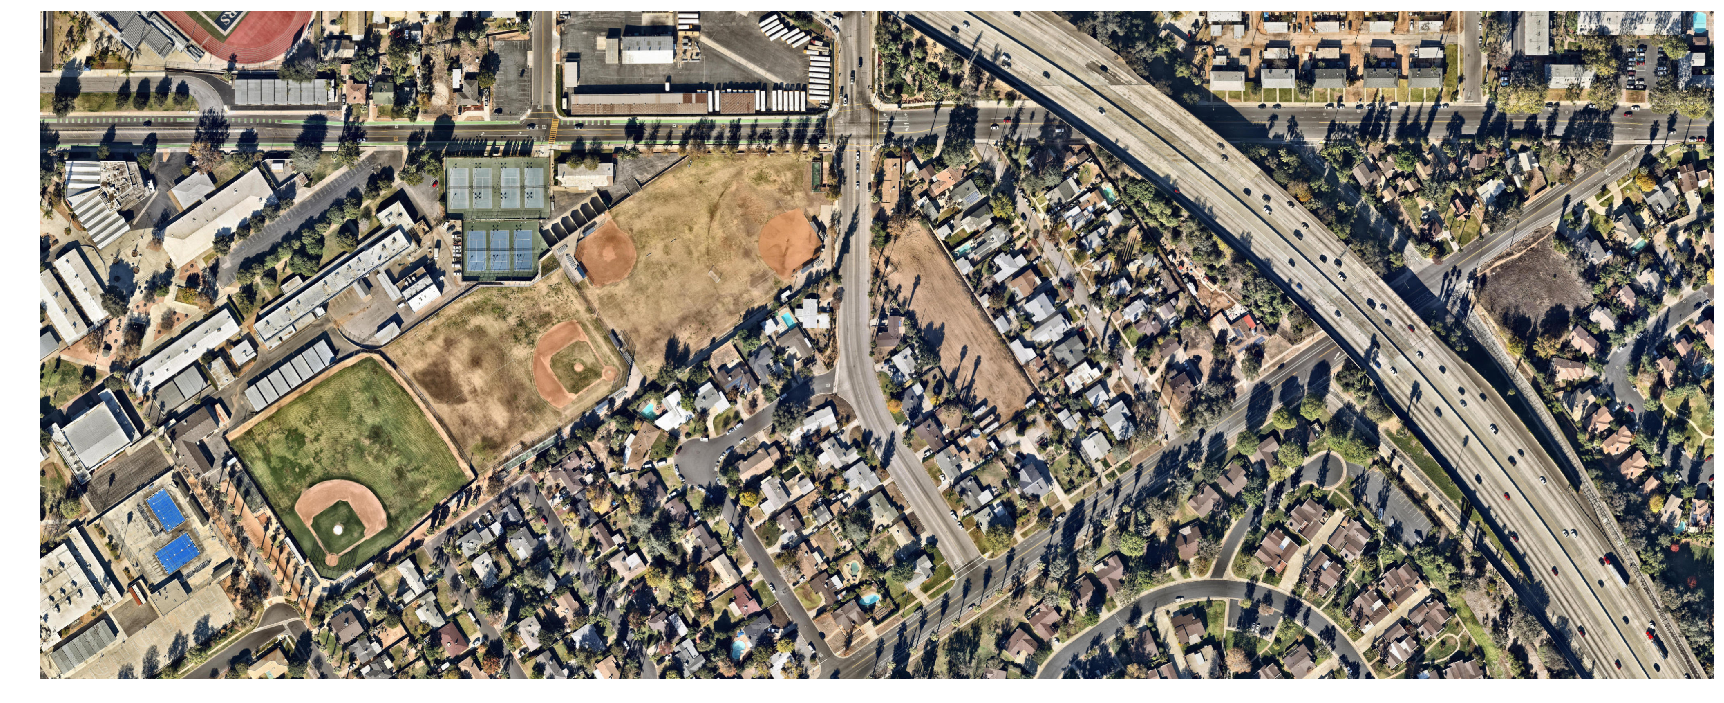

In [5]:
URL = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/export?'
extent = arc_map.extent
print(extent)

y_delta = (extent['ymax'] - extent['ymin'])
x_delta = (extent['xmax'] - extent['xmin'])

MAP_HEIGHT = round(MAP_WIDTH * y_delta /  x_delta)

parameters = {
    'bbox':'{},{},{},{}'.format(extent['xmin'], extent['ymin'], extent['xmax'], extent['ymax']),
    'bboxSR':extent['spatialReference']['latestWkid'],
    'size':'{},{}'.format(MAP_WIDTH, MAP_HEIGHT),
    'format':'jpg',
    'f':'image'
}

URL += urlencode(parameters)

MAP_FILE_PATH = join(TEMP_DIR, MAP_NAME)

if urlretrieve(URL, MAP_FILE_PATH):
    
    img = image.load_img(MAP_FILE_PATH, target_size=(MAP_HEIGHT, MAP_WIDTH)) 
    plt.figure(figsize=(30, 30)) 
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Multilabel Classifer
Predict the class of tiles using multilabel classifer and display the output

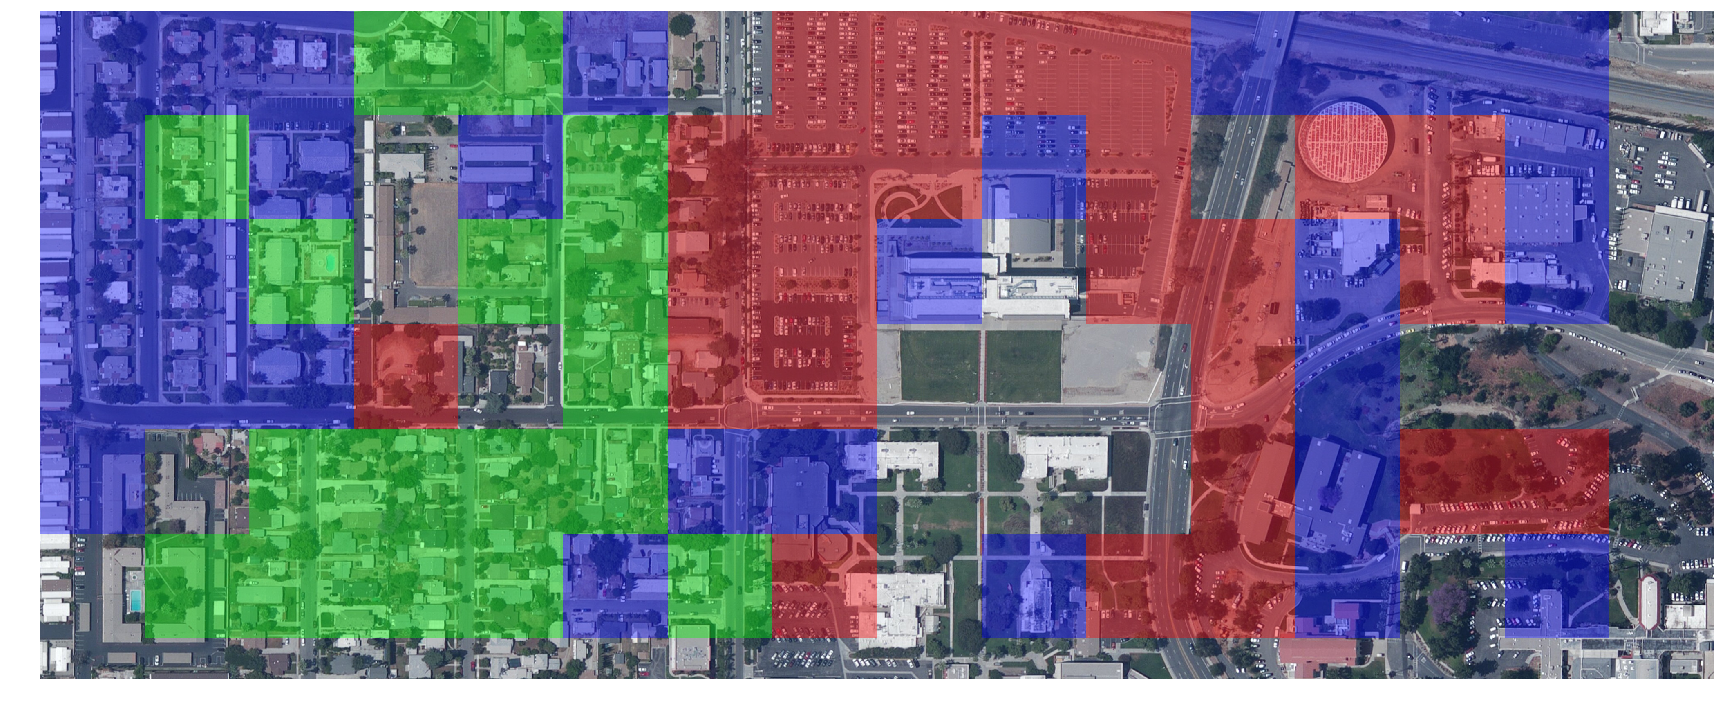

In [13]:
overlay_color_options = {
           0 : (0, 255, 0, 0), # agricultural
           1 : (0, 255, 0, 0), # buildings
           2 : (0, 255, 255, 0), # land
           3 : (255, 0, 0, 100), # red for parking
           4 : (0, 255, 0, 100), # green for buildings
           5 : (0, 0, 255, 100), # blue for roads
}

bounding_boxes = defaultdict(list)

def predict_class_overlay(map_image, box, model, idx):
    
    cropped_image = map_image.crop(box)
    cropped_image.save(join(TEMP_SLICED_SUBDIR, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)
    img_resized = cropped_image.resize((128,128), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img_resized)
    img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
    img_tensor /= 255.
    predictions = model.predict(img_tensor)[0]
    max_val = np.amax(predictions)
    max_index = np.argmax(predictions)

    return overlay_color_options[max_index]


with Image.open(MAP_FILE_PATH) as map_image:
    
    
    imgwidth, imgheight = map_image.size

    MODEL_PATH =  join(MODEL_DIR, 'redlands_multi_classifier_model.h5');
    model = load_model(MODEL_PATH)
    model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
        
  
    idx = 0
    for i in range(0, imgheight - SLICE_HEIGHT , SLICE_HEIGHT):
        for j in range(0, imgwidth - SLICE_WIDTH, SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                
                overlay_color = predict_class_overlay(map_image, box, model, idx)
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)  
                map_image.paste(overlay, (j, i), overlay)
                  
            except:
                traceback.print_exc()
                pass
            idx +=1
    map_image.save(join(OUTPUT_DIR, 'muti_classifier_map_output.jpg'), "JPEG", quality=100, optimize=True)
    plt.figure(figsize=(30, 30)) 
    plt.imshow(map_image)
    plt.axis('off')
    plt.show()

### Binary Classifer
Predict the class of tiles using multilabel classifer and display the output

90


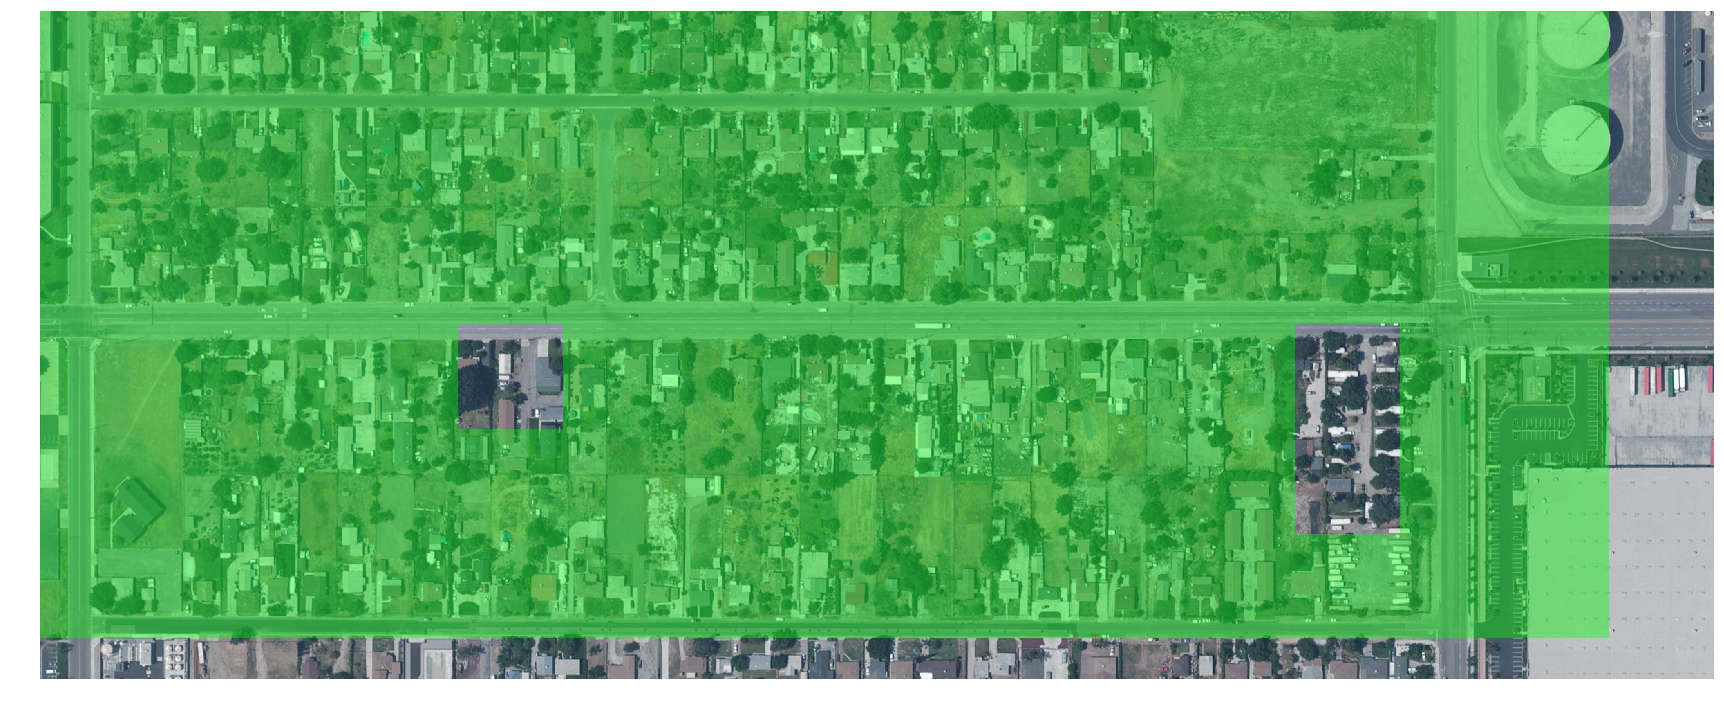

In [28]:
overlay_color_options = {
           0 : (0, 255, 0, 0), # agricultural
           1 : (0, 255, 0, 0), # buildings
           2 : (0, 255, 255, 0), # land
           3 : (255, 0, 0, 100), # red for parking
           4 : (0, 255, 0, 100), # green for buildings
           5 : (0, 0, 255, 100), # blue for roads
}

def predict_class_overlay(map_image, box, model, idx):
    
    cropped_image = map_image.crop(box)
    cropped_image.save(join(TEMP_SLICED_SUBDIR, 'image_{}.jpg'.format(idx)), "JPEG", quality=100, optimize=True)
    img_resized = cropped_image.resize((128,128), Image.ANTIALIAS)
    img_tensor = image.img_to_array(img_resized)
    img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
    img_tensor /= 255.
    predictions = model.predict(img_tensor)
    if predictions[0] >= 0.5:
        return (0, 255, 0, 100)
    else:
        return (0, 255, 0, 0)



with Image.open(MAP_FILE_PATH) as map_image:
     
    
    imgwidth, imgheight = map_image.size
    
    MODEL_PATH =  join(MODEL_DIR, 'roads_binary_classifer_model.h5');
    model = load_model(MODEL_PATH)
    model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
   
        
    idx = 0
    for i in range(0, imgheight - SLICE_HEIGHT , SLICE_HEIGHT):
        for j in range(0, imgwidth - SLICE_WIDTH, SLICE_WIDTH):
            box = (j, i, j + SLICE_WIDTH, i + SLICE_HEIGHT)
            try:
                
                overlay_color = predict_class_overlay(map_image, box, model, idx)
                overlay = Image.new('RGBA', ( SLICE_WIDTH, SLICE_HEIGHT), overlay_color)  
                map_image.paste(overlay, (j, i), overlay)
                  
            except:
                traceback.print_exc()
                pass
            idx +=1
    print(idx) 
    map_image.save(join(OUTPUT_DIR, 'binary_classsifer_map_output.jpg'), "JPEG", quality=100, optimize=True)
    plt.figure(figsize=(30, 30)) 
    plt.imshow(map_image)
    plt.axis('off')
    plt.show()